# An Exploration of NYC 311 Data

In this project, we will be exploring data on 311 service requests in New York City. The 311 number is one that constituents can call to request city services. It is intended to be an alternative to the 911 number, where constituents report emergencies.  

This analysis will focus on requests from the year 2015 that were assigned to the New York Police Department. We will explore this data for trends that could be used by the city to help improve their services. We will try to answer questions such as:
* Are there trends by season? By month? By hour of the day?
* What about geographic trends (i.e. trends by borough)?
* How long, on average, does it take to close a request? Does that vary by borough? By complaint type?
* Are there any trends with how these service requests are resolved?

The source data for this project can be found on [Kaggle](https://www.kaggle.com/sherinclaudia/nyc311-2010#311_Service_Requests_from_2010_to_Present.csv). A more complete dataset covering 2010 to the present, and including over 28 million rows, is available on [New York City's open data website](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9).

## Read In and Explore the Data

In [1]:
import pandas as pd

In [2]:
requests = pd.read_csv('/Users/alexustian/stacey_learning/311_Service_Requests.csv')

/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
requests.shape

(364558, 53)

In [4]:
requests.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,32310363,12/31/2015 11:59:45 PM,01/01/2016 12:55:15 AM,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,10034,71 VERMILYEA AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.865682,-73.923501,"(40.86568153633767, -73.92350095571744)"
1,32309934,12/31/2015 11:59:44 PM,01/01/2016 01:26:57 AM,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,11105,27-07 23 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.775945,-73.915094,"(40.775945312321085, -73.91509393898605)"
2,32309159,12/31/2015 11:59:29 PM,01/01/2016 04:51:03 AM,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,10458,2897 VALENTINE AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.870325,-73.888525,"(40.870324522111424, -73.88852464418646)"
3,32305098,12/31/2015 11:57:46 PM,01/01/2016 07:43:13 AM,NYPD,New York City Police Department,Illegal Parking,Commercial Overnight Parking,Street/Sidewalk,10461,2940 BAISLEY AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.835994,-73.828379,"(40.83599404683083, -73.82837939584206)"
4,32306529,12/31/2015 11:56:58 PM,01/01/2016 03:24:42 AM,NYPD,New York City Police Department,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,11373,87-14 57 ROAD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.733060,-73.874170,"(40.733059618956815, -73.87416975810375)"


In [5]:
requests.dtypes

Unique Key                          int64
Created Date                       object
Closed Date                        object
Agency                             object
Agency Name                        object
Complaint Type                     object
Descriptor                         object
Location Type                      object
Incident Zip                      float64
Incident Address                   object
Street Name                        object
Cross Street 1                     object
Cross Street 2                     object
Intersection Street 1              object
Intersection Street 2              object
Address Type                       object
City                               object
Landmark                           object
Facility Type                      object
Status                             object
Due Date                           object
Resolution Description             object
Resolution Action Updated Date     object
Community Board                   

From this brief examination of the data, we can see that there are a number of columns that are not relevant to our analysis. There are also a few date columns that need to be converted from an object data type to datetime.

We will also need to add a few columns that will be used in our analysis: season, hour of the request, and resolution time.

## Data Cleaning

We will start by removing the unnecessary columns, and renaming any remaining columns for clarity, as necessary.

In [6]:
columns = ['Unique Key', 'Created Date', 'Closed Date', 'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',\
           'Address Type', 'City', 'Resolution Description', 'Borough', 'Latitude', 'Longitude']
requests = requests.loc[:,columns]

Let's confirm that we now have a dataframe with only the expected 13 columns instead of 53.

In [7]:
requests.shape

(364558, 13)

Now we can clean up the column name formatting.

In [8]:
requests.columns = requests.columns.str.replace(" ", "_").str.lower()
requests.columns

Index([u'unique_key', u'created_date', u'closed_date', u'complaint_type',
       u'descriptor', u'location_type', u'incident_zip', u'address_type',
       u'city', u'resolution_description', u'borough', u'latitude',
       u'longitude'],
      dtype='object')

Almost all of these column names are self-explanatory, with the exception of the "Descriptor" column. From the data dictionary on the [NYC Open Data website](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9), we know that the column includes further details on the complaint type. Therefore, we can rename it to reflect this.

In [9]:
requests = requests.rename(columns={"descriptor": "complaint_description"})

Next we will convert the date columns to datetime format.

In [10]:
requests['created_date'] =  pd.to_datetime(requests['created_date'], format='%m/%d/%Y %I:%M:%S %p')
requests['closed_date'] =  pd.to_datetime(requests['closed_date'], format='%m/%d/%Y %I:%M:%S %p')

Now we can add the three columns that we will need for analysis purposes: season, hour of request, and resolution time. For the hour, we can simply extract the hour field from the time that the request was created. For the season, we will write a function to identify the season based on the month that the request was created.

In [11]:
requests['hour'] = requests['created_date'].dt.hour
requests['month'] = requests['created_date'].dt.month #adding this column for the season identification, below

def add_season(row):
    if (row["month"] == 1) | (row["month"] == 2) | (row["month"] == 12):
        return "Winter"
    elif (row["month"] == 3) | (row["month"] == 4) | (row["month"] == 5):
        return "Spring"
    elif (row["month"] == 6) | (row["month"] == 7) | (row["month"] == 8):
        return "Summer"
    else:
        return "Autumn"

requests['season'] = requests.apply(add_season, axis=1)

While the month column is not one that was initially identified as necessary for our analysis, and could therefore be deleted, we will leave it in in case it's useful for future analyses. 

Now we will compute the resolution time in minutes by subtracting the date created from the date closed, and displaying the result in minutes.

In [12]:
requests['resolution_time_m'] = (requests.closed_date-requests.created_date).astype('timedelta64[m]')

Let's check to make sure the columns were all added correctly.

In [13]:
requests.head()

,unique_key,created_date,closed_date,complaint_type,complaint_description,location_type,incident_zip,address_type,city,resolution_description,borough,latitude,longitude,hour,month,season,resolution_time_m
0,32310363,2015-12-31 23:59:45,2016-01-01 00:55:15,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,10034,ADDRESS,NEW YORK,The Police Department responded and upon arriv...,MANHATTAN,40.865682,-73.923501,23,12,Winter,55
1,32309934,2015-12-31 23:59:44,2016-01-01 01:26:57,Blocked Driveway,No Access,Street/Sidewalk,11105,ADDRESS,ASTORIA,The Police Department responded to the complai...,QUEENS,40.775945,-73.915094,23,12,Winter,87
2,32309159,2015-12-31 23:59:29,2016-01-01 04:51:03,Blocked Driveway,No Access,Street/Sidewalk,10458,ADDRESS,BRONX,The Police Department responded and upon arriv...,BRONX,40.870325,-73.888525,23,12,Winter,291
3,32305098,2015-12-31 23:57:46,2016-01-01 07:43:13,Illegal Parking,Commercial Overnight Parking,Street/Sidewalk,10461,ADDRESS,BRONX,The Police Department responded to the complai...,BRONX,40.835994,-73.828379,23,12,Winter,465
4,32306529,2015-12-31 23:56:58,2016-01-01 03:24:42,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,11373,ADDRESS,ELMHURST,The Police Department responded and upon arriv...,QUEENS,40.733060,-73.874170,23,12,Winter,207


Since this analysis will frequently consider complaint types, let's take a quick look at those values to see if any cleanup is needed.

In [14]:
requests['complaint_type'].value_counts()

Blocked Driveway             100881
Illegal Parking               92679
Noise - Street/Sidewalk       51692
Noise - Commercial            44109
Derelict Vehicle              21661
Noise - Vehicle               19352
Animal Abuse                  10541
Traffic                        5198
Homeless Encampment            4879
Vending                        4192
Noise - Park                   4109
Drinking                       1409
Noise - House of Worship       1070
Posting Advertisement           681
Urinating in Public             641
Bike/Roller/Skate Chronic       478
Panhandling                     327
Disorderly Youth                315
Illegal Fireworks               172
Graffiti                        157
Agency Issues                     8
Squeegee                          4
Ferry Complaint                   2
Animal in a Park                  1
Name: complaint_type, dtype: int64

From this, we can see that the noise complaints are broken up into five different categories.  While it may be interesting to look at those breakdowns later in the analysis, we want our top level complaint type to just be "Noise". Therefore, we'll pull the noise types out into their own column for future use.

In [15]:
requests['noise_type'] = requests['complaint_type'].str.split(' - ').str.get(1)
requests['complaint_type'] = requests['complaint_type'].str.split(' - ').str.get(0)
requests['complaint_type'].value_counts()

Noise                        120332
Blocked Driveway             100881
Illegal Parking               92679
Derelict Vehicle              21661
Animal Abuse                  10541
Traffic                        5198
Homeless Encampment            4879
Vending                        4192
Drinking                       1409
Posting Advertisement           681
Urinating in Public             641
Bike/Roller/Skate Chronic       478
Panhandling                     327
Disorderly Youth                315
Illegal Fireworks               172
Graffiti                        157
Agency Issues                     8
Squeegee                          4
Ferry Complaint                   2
Animal in a Park                  1
Name: complaint_type, dtype: int64

Now let's check to make sure that there are no duplicate rows in our dataset. Each service request is given a unique number (the "unique_key" field in our dataset), so we will check for duplicates in that column.

In [16]:
dups = requests.duplicated(['unique_key'])
requests[dups]

,unique_key,created_date,closed_date,complaint_type,complaint_description,location_type,incident_zip,address_type,city,resolution_description,borough,latitude,longitude,hour,month,season,resolution_time_m,noise_type


Since the dataframe is empty, we know that there are not duplicate rows with the same unique key.  

Finally, let's quickly check for any null values, and either fill or delete them as necessary.

In [17]:
requests.isnull().sum()

unique_key                     0
created_date                   0
closed_date                 2381
complaint_type                 0
complaint_description       6501
location_type                133
incident_zip                2998
address_type                3252
city                        2997
resolution_description         0
borough                        0
latitude                    4030
longitude                   4030
hour                           0
month                          0
season                         0
resolution_time_m           2381
noise_type                244226
dtype: int64

A fair portion of our analysis will be looking at geographic trends, so let's first examine the rows where the 'city' field is null.

In [18]:
requests[requests["city"].isnull()].head(10)

,unique_key,created_date,closed_date,complaint_type,complaint_description,location_type,incident_zip,address_type,city,resolution_description,borough,latitude,longitude,hour,month,season,resolution_time_m,noise_type
33,32306700,2015-12-31 23:18:10,2016-01-02 01:04:03,Illegal Parking,Double Parked Blocking Traffic,Street/Sidewalk,NaN,NaN,NaN,The Police Department issued a summons in resp...,Unspecified,NaN,NaN,23,12,Winter,1545,NaN
283,32309451,2015-12-31 17:40:16,2016-01-01 10:59:11,Illegal Parking,Blocked Hydrant,Street/Sidewalk,NaN,NaN,NaN,The Police Department issued a summons in resp...,Unspecified,NaN,NaN,17,12,Winter,1038,NaN
302,32309860,2015-12-31 17:05:30,2016-01-01 08:17:35,Blocked Driveway,Partial Access,Street/Sidewalk,NaN,NaN,NaN,The Police Department responded to the complai...,Unspecified,NaN,NaN,17,12,Winter,912,NaN
416,32305700,2015-12-31 14:16:04,NaT,Illegal Parking,Posted Parking Sign Violation,Street/Sidewalk,NaN,NaN,NaN,Your complaint has been forwarded to the New Y...,Unspecified,NaN,NaN,14,12,Winter,NaN,NaN
611,32309308,2015-12-31 09:58:06,NaT,Noise,Loud Music/Party,Street/Sidewalk,NaN,NaN,NaN,Your complaint has been forwarded to the New Y...,Unspecified,NaN,NaN,9,12,Winter,NaN,Street/Sidewalk
1421,32299438,2015-12-30 11:55:25,2015-12-30 14:35:54,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,NaN,NaN,NaN,The Police Department responded to the complai...,Unspecified,NaN,NaN,11,12,Winter,160,NaN
1648,32303348,2015-12-30 05:13:42,NaT,Illegal Parking,Commercial Overnight Parking,Street/Sidewalk,NaN,NaN,NaN,Your complaint has been forwarded to the New Y...,Unspecified,NaN,NaN,5,12,Winter,NaN,NaN
1816,32294519,2015-12-29 22:44:50,NaT,Derelict Vehicle,With License Plate,Street/Sidewalk,NaN,NaN,NaN,Your complaint has been forwarded to the New Y...,Unspecified,NaN,NaN,22,12,Winter,NaN,NaN
1965,32296487,2015-12-29 19:09:13,NaT,Derelict Vehicle,With License Plate,Street/Sidewalk,NaN,NaN,NaN,Your complaint has been forwarded to the New Y...,Unspecified,NaN,NaN,19,12,Winter,NaN,NaN
1987,32293372,2015-12-29 18:31:39,NaT,Illegal Parking,Commercial Overnight Parking,Street/Sidewalk,NaN,NaN,NaN,Your complaint has been forwarded to the New Y...,Unspecified,NaN,NaN,18,12,Winter,NaN,NaN


There is no information in these rows that will help us determine the correct values for the 'city' field. Even more interesting is that there are non-null values in the 'borough' column that are listed as "Unspecified". We are interested in concrete values for the 'borough' field, so let's take a look at the rows where that is unspecified.

In [19]:
requests[requests['borough'] == 'Unspecified'].head(10)

,unique_key,created_date,closed_date,complaint_type,complaint_description,location_type,incident_zip,address_type,city,resolution_description,borough,latitude,longitude,hour,month,season,resolution_time_m,noise_type
33,32306700,2015-12-31 23:18:10,2016-01-02 01:04:03,Illegal Parking,Double Parked Blocking Traffic,Street/Sidewalk,NaN,NaN,NaN,The Police Department issued a summons in resp...,Unspecified,NaN,NaN,23,12,Winter,1545,NaN
283,32309451,2015-12-31 17:40:16,2016-01-01 10:59:11,Illegal Parking,Blocked Hydrant,Street/Sidewalk,NaN,NaN,NaN,The Police Department issued a summons in resp...,Unspecified,NaN,NaN,17,12,Winter,1038,NaN
302,32309860,2015-12-31 17:05:30,2016-01-01 08:17:35,Blocked Driveway,Partial Access,Street/Sidewalk,NaN,NaN,NaN,The Police Department responded to the complai...,Unspecified,NaN,NaN,17,12,Winter,912,NaN
416,32305700,2015-12-31 14:16:04,NaT,Illegal Parking,Posted Parking Sign Violation,Street/Sidewalk,NaN,NaN,NaN,Your complaint has been forwarded to the New Y...,Unspecified,NaN,NaN,14,12,Winter,NaN,NaN
611,32309308,2015-12-31 09:58:06,NaT,Noise,Loud Music/Party,Street/Sidewalk,NaN,NaN,NaN,Your complaint has been forwarded to the New Y...,Unspecified,NaN,NaN,9,12,Winter,NaN,Street/Sidewalk
1421,32299438,2015-12-30 11:55:25,2015-12-30 14:35:54,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,NaN,NaN,NaN,The Police Department responded to the complai...,Unspecified,NaN,NaN,11,12,Winter,160,NaN
1648,32303348,2015-12-30 05:13:42,NaT,Illegal Parking,Commercial Overnight Parking,Street/Sidewalk,NaN,NaN,NaN,Your complaint has been forwarded to the New Y...,Unspecified,NaN,NaN,5,12,Winter,NaN,NaN
1816,32294519,2015-12-29 22:44:50,NaT,Derelict Vehicle,With License Plate,Street/Sidewalk,NaN,NaN,NaN,Your complaint has been forwarded to the New Y...,Unspecified,NaN,NaN,22,12,Winter,NaN,NaN
1965,32296487,2015-12-29 19:09:13,NaT,Derelict Vehicle,With License Plate,Street/Sidewalk,NaN,NaN,NaN,Your complaint has been forwarded to the New Y...,Unspecified,NaN,NaN,19,12,Winter,NaN,NaN
1987,32293372,2015-12-29 18:31:39,NaT,Illegal Parking,Commercial Overnight Parking,Street/Sidewalk,NaN,NaN,NaN,Your complaint has been forwarded to the New Y...,Unspecified,NaN,NaN,18,12,Winter,NaN,NaN


These ~3,000 rows contain a number of missing values in other columns, and represent a relatively small portion of our total 364,000+ rows, so they will be excluded from our dataset.

In [20]:
requests = requests[requests['borough'] != 'Unspecified']
requests.shape

(361600, 18)

Let's see how many null values that leaves us with.

In [21]:
requests.isnull().sum()

unique_key                     0
created_date                   0
closed_date                   58
complaint_type                 0
complaint_description       6493
location_type                122
incident_zip                  41
address_type                 295
city                          41
resolution_description         0
borough                        0
latitude                    1073
longitude                   1073
hour                           0
month                          0
season                         0
resolution_time_m             58
noise_type                242380
dtype: int64

We can drop the remaining 41 rows that have null values for 'city'.

In [22]:
requests = requests.dropna(subset=['city'])

Now let's take a look at the rows with null values for the 'closed_date' column.

In [23]:
requests[requests["closed_date"].isnull()].head(10)

,unique_key,created_date,closed_date,complaint_type,complaint_description,location_type,incident_zip,address_type,city,resolution_description,borough,latitude,longitude,hour,month,season,resolution_time_m,noise_type
2149,32290742,2015-12-29 14:27:24,NaT,Blocked Driveway,No Access,Street/Sidewalk,10016,ADDRESS,NEW YORK,The Police Department responded to the complai...,MANHATTAN,40.742854,-73.979134,14,12,Winter,NaN,NaN
4715,32276857,2015-12-26 15:27:13,NaT,Illegal Parking,Blocked Hydrant,Street/Sidewalk,10019,ADDRESS,NEW YORK,Your complaint has been forwarded to the New Y...,MANHATTAN,40.763425,-73.990766,15,12,Winter,NaN,NaN
9714,32242018,2015-12-20 22:53:09,NaT,Noise,Loud Music/Party,Store/Commercial,11221,ADDRESS,BROOKLYN,The Police Department responded to the complai...,BROOKLYN,40.696223,-73.933916,22,12,Winter,NaN,Commercial
12938,32223714,2015-12-17 18:46:39,NaT,Derelict Vehicle,With License Plate,Street/Sidewalk,10470,ADDRESS,BRONX,Your complaint has been forwarded to the New Y...,BRONX,40.901292,-73.864931,18,12,Winter,NaN,NaN
16703,32193279,2015-12-13 22:24:59,NaT,Noise,Loud Talking,Store/Commercial,10472,ADDRESS,BRONX,Your complaint has been forwarded to the New Y...,BRONX,40.830362,-73.866022,22,12,Winter,NaN,Commercial
17558,32190330,2015-12-13 02:07:52,NaT,Noise,Loud Music/Party,Street/Sidewalk,10451,ADDRESS,BRONX,The Police Department responded to the complai...,BRONX,40.820065,-73.920930,2,12,Winter,NaN,Street/Sidewalk
18513,32186590,2015-12-12 14:47:35,NaT,Noise,Loud Music/Party,Street/Sidewalk,10026,LATLONG,NEW YORK,Your complaint has been forwarded to the New Y...,MANHATTAN,40.802855,-73.954767,14,12,Winter,NaN,Street/Sidewalk
18945,32184523,2015-12-12 04:31:29,NaT,Blocked Driveway,No Access,Street/Sidewalk,11418,ADDRESS,RICHMOND HILL,Your complaint has been forwarded to the New Y...,QUEENS,40.696911,-73.841103,4,12,Winter,NaN,NaN
20759,32171861,2015-12-10 17:49:27,NaT,Noise,Loud Talking,Street/Sidewalk,10472,INTERSECTION,BRONX,Your complaint has been forwarded to the New Y...,BRONX,40.829931,-73.865914,17,12,Winter,NaN,Street/Sidewalk
20804,32171381,2015-12-10 17:03:14,NaT,Illegal Parking,Double Parked Blocking Traffic,Street/Sidewalk,10009,LATLONG,NEW YORK,Your complaint has been forwarded to the New Y...,MANHATTAN,40.720113,-73.976948,17,12,Winter,NaN,NaN


There aren't any obvious hints as to why these don't have a closed date, and it's quite possible that it's due to a clerical error. Since there are so few rows that are affected, we will drop them from the dataset instead of filling them with any values.

In [24]:
requests = requests.dropna(subset=['closed_date'])
requests.isnull().sum()

unique_key                     0
created_date                   0
closed_date                    0
complaint_type                 0
complaint_description       6492
location_type                122
incident_zip                   3
address_type                 292
city                           0
resolution_description         0
borough                        0
latitude                    1073
longitude                   1073
hour                           0
month                          0
season                         0
resolution_time_m              0
noise_type                242347
dtype: int64

For now we will leave the remaining null values/rows in place, and can delete of fill them later if our analysis requires it.

## Trends Over Time - Season, Month, Hour of the Day

Now that our data has been imported and cleaned up, we're ready to begin our analysis.  Let's start with the first question: Are there trends by season? By month? By hour of the day? 

Our first step is to group the complaints by season, and then plot them to look for any trends.

In [25]:
import matplotlib.pyplot as plt
from numpy import arange #importing this so that we can position bars in our bar charts
%matplotlib inline

complaints_by_season = requests.groupby('season').size().to_frame('total')

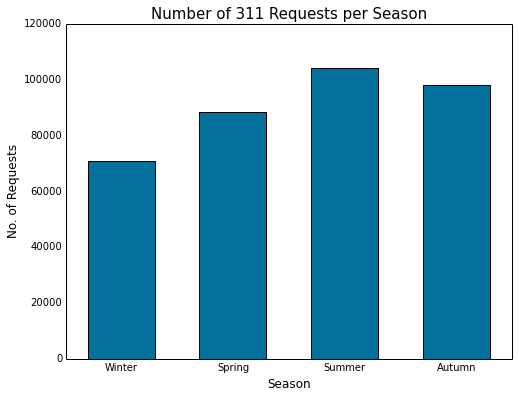

In [26]:
seasons = ['Winter', 'Spring', 'Summer', 'Autumn'] #for use in setting xtick labels
#Using .loc[] below to set the order of the bars in our chart so that they appear in chronological order instead of 
#alphabetical order.
totals = complaints_by_season['total'].loc(axis=0)['Winter', 'Spring', 'Summer', 'Autumn'].values
bar_positions = arange(4) + 0.7

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(bar_positions, totals, 0.6, color='#03719c')
ax.set_xticks(range(1,5))
ax.set_xticklabels(seasons)
ax.tick_params(bottom='off', top='off', left='off', right='off')

plt.xlabel('Season', fontdict = {'fontsize' : 12})
plt.ylabel('No. of Requests', fontdict = {'fontsize' : 12})
plt.title('Number of 311 Requests per Season', fontdict = {'fontsize' : 15});

From this quick graph we can see that there are the fewest 311 requests in the winter, and the most in summer, but it would be much more helpful to see if there are trends in complaint *type* per season. 

From our earlier examination of the data, we know that there are five types of complaints that account for 95 percent of 311 requests: noise, blocked driveway, illegal parking, derelict vehicle, and animal abuse. In order to make things a bit easier to plot and analyze, we will limit our dataset to those five complaint types.

In [27]:
top_complaints = ['Noise', 'Blocked Driveway', 'Illegal Parking', 'Derelict Vehicle', 'Animal Abuse']
top_requests = requests[requests.complaint_type.isin(top_complaints)]

Now we will group the new dataset by season, and then pivot the result so that it is more conducive to plotting.

In [28]:
grouped = top_requests.groupby(['season', 'complaint_type']).size().to_frame('total').reset_index()
grouped_pivot = grouped.pivot(index='season', columns='complaint_type', values='total')

Now we are ready to plot these results to see if there are any trends that stand out.

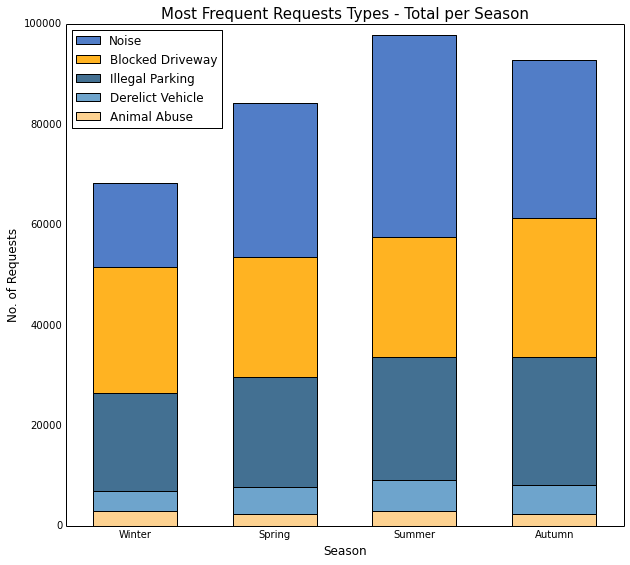

In [29]:
fig, ax = plt.subplots(figsize=(10,9))

#The following list of labels will be used to set the layering of the stacked bar chart. The order was determined 
#by looking at the list of value counts for the complaint_type field in our earlier data cleaning.
labels = ['Animal Abuse','Derelict Vehicle', 'Illegal Parking', 'Blocked Driveway', 'Noise']
colors = ['#fdd291', '#6ea4cc', '#437092', '#ffb322', '#517dc7']
width = 0.6

prevBar = 0
for index, label in enumerate(labels):
    values = grouped_pivot[label].loc(axis=0)['Winter', 'Spring', 'Summer', 'Autumn'].values
    ax.bar(
        bar_positions, values, width, 
        label=labels[index], color=colors[index], bottom=prevBar
    )
    prevBar += values 

ax.set_xticks(range(1,5))
ax.set_xticklabels(seasons)
ax.tick_params(bottom='off', top='off', left='off', right='off')

#The following two lines of code set the order of the entries in the legend so that they match the order in which
#they appear in the stacked bar graph.
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='upper left')

plt.xlabel('Season', fontdict = {'fontsize' : 12})
plt.ylabel('No. of Requests', fontdict = {'fontsize' : 12})
plt.title('Most Frequent Requests Types - Total per Season', fontdict = {'fontsize' : 15});

The main thing that this chart reveals is that there are significantly more noise complaints in the summer than there are in the winter. This is perhaps unsurprising, given that more people are outside in public spaces in warmer weather. When more people are out, it usually also means that there are people doing things like playing music that might cause someone to call in a noise complaint. 

This chart also show that there are more blocked driveway complaints in the winter and autumn. 

## Future Updates

The next update to this project will focus on analyzing complaints by month and complaints by hour of the day.

Later, we will turn to the remaining questions from the list that was initially posed:
* Are there geographic trends for complaint type (i.e. trends by borough)?
* How long, on average, does it take to close a request? Does that vary by borough? By complaint type?
* Are there any trends with how these service requests are resolved?